In [1]:
### JUPYTER NOTEBOOK / MODULE PATH FIX ###
import sys

if "/share/apps/python/3.8.6/intel/lib/python3.8" in sys.path and sys.path[1] == '':
    sys.path[1], sys.path[6] = sys.path[6], sys.path[1]

In [3]:
from jtb_2022_code.utils.figure_data import FigureSingleCellData

from jtb_2022_code.figure_4 import plot_figure_4

In [4]:
## LOAD AND PROCESS VELOCITY AND DECAY ###
data = FigureSingleCellData()

Reading Single Cell Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_fpr1.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_fpr1.h5ad


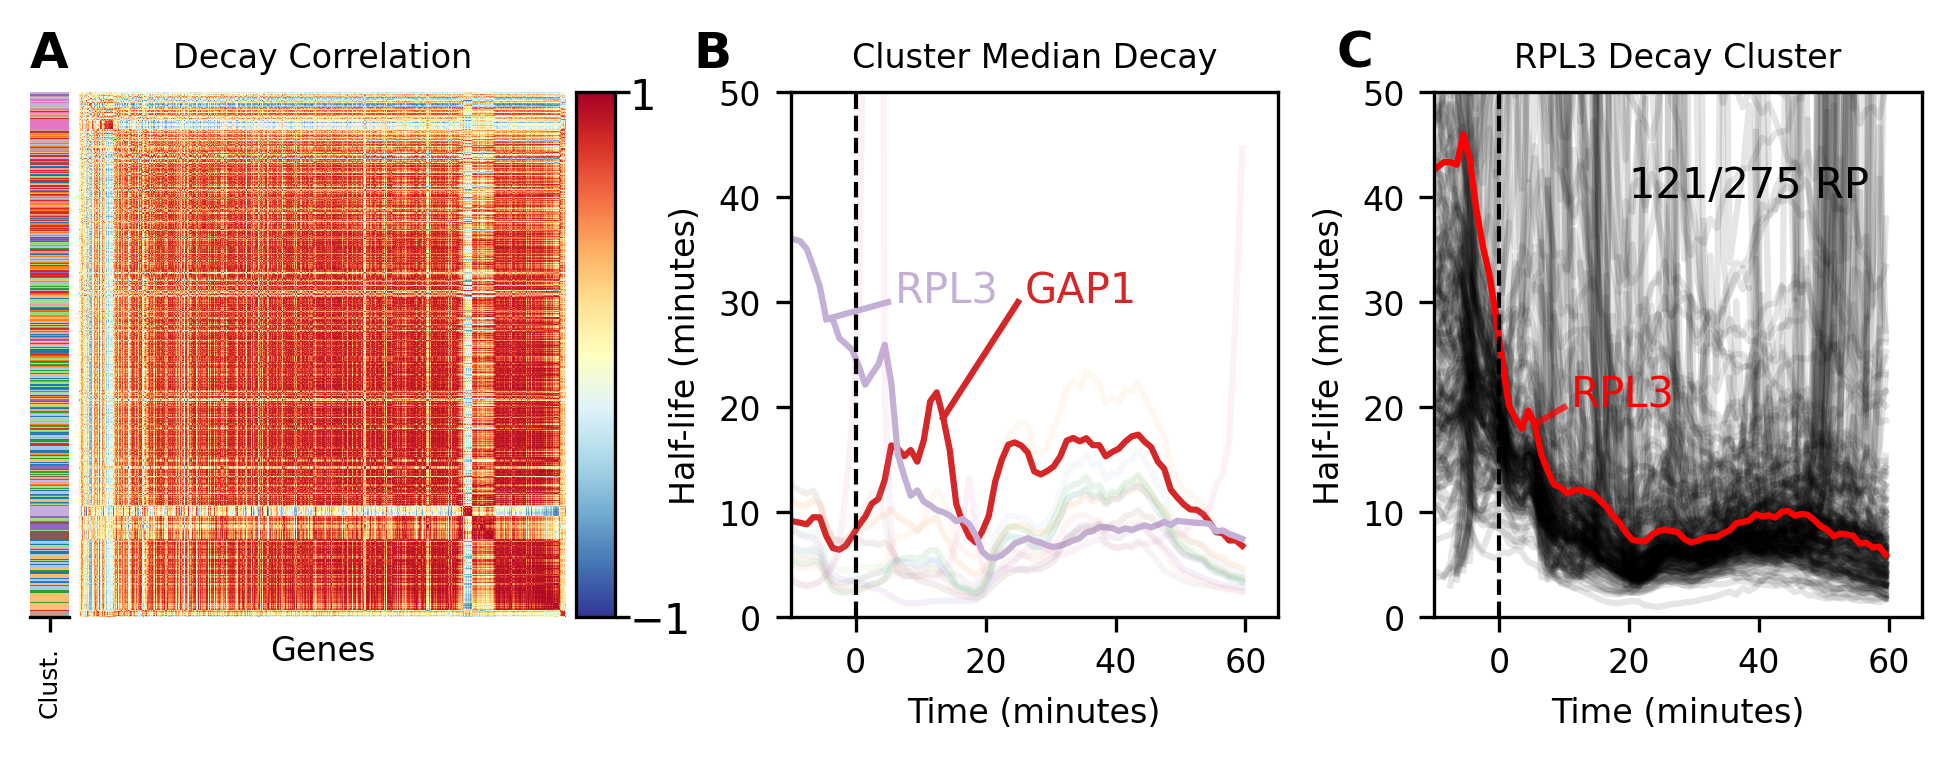

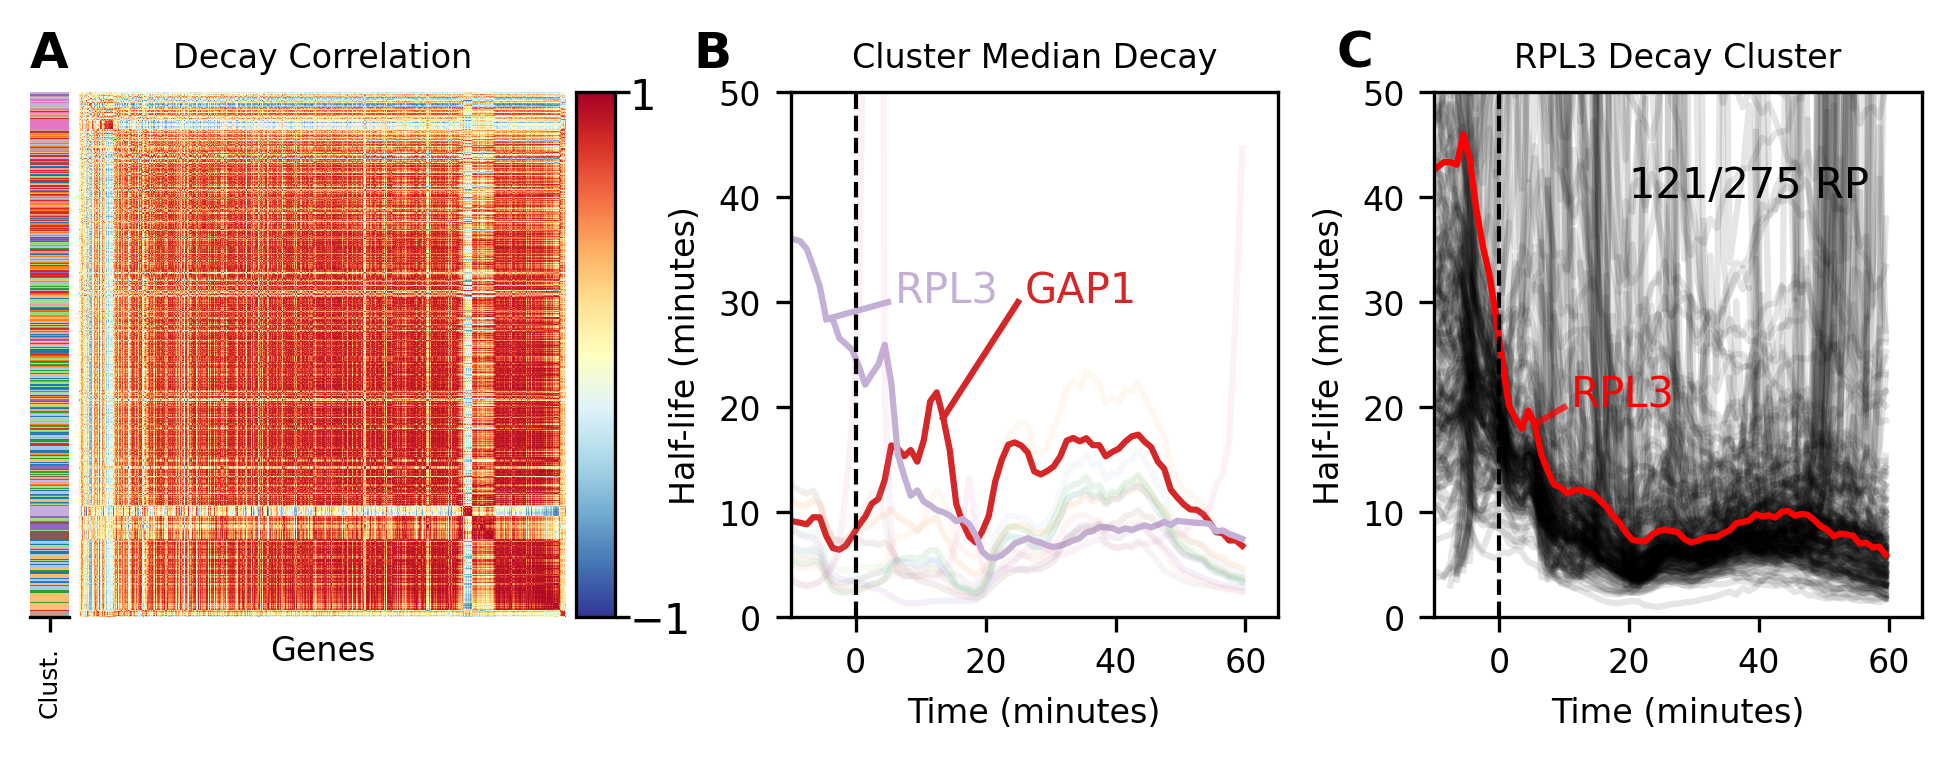

In [5]:
plot_figure_4(data)

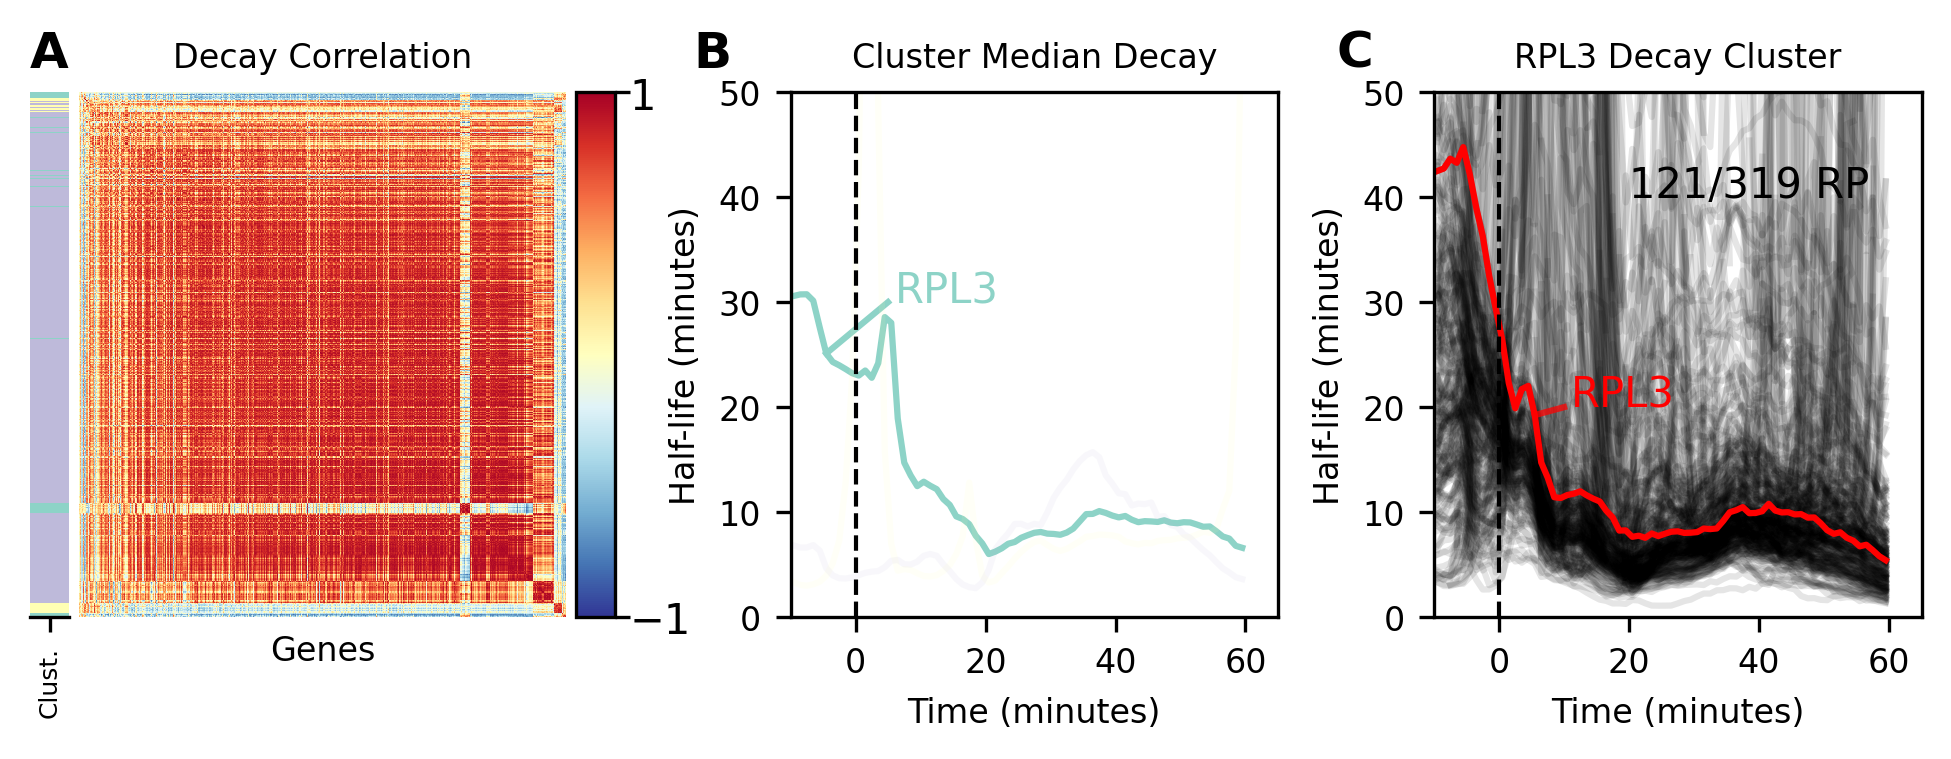

In [25]:
from jtb_2022_code.utils.figure_common import *
from jtb_2022_code.figure_constants import *
from jtb_2022_code.utils.decay_common import _halflife

import numpy as np
import pandas as pd

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

from inferelator_velocity.programs import _leiden_cluster

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import sys
sys.setrecursionlimit(10000)

_gene_idx = data.all_data.var['programs'] == data.all_data.uns['programs']['rapa_program']
_gene_idx &= np.any(np.abs(data.all_data.varm['rapamycin_window_decay']) != 0, axis=1)

corr_mat = np.corrcoef(data.all_data.varm['rapamycin_window_decay'][_gene_idx, :])
dist_mat = 1 - corr_mat

fig = plt.figure(figsize=(6.5, 2.5), dpi=300)

axd = {
    'clusters': fig.add_axes([0.02, 0.15, 0.02, 0.7]),
    'matrix': fig.add_axes([0.045, 0.15, 0.25, 0.7]),
    'info_cbar': fig.add_axes([0.3, 0.15, 0.02, 0.7]),
    'median': fig.add_axes([0.41, 0.15, 0.25, 0.7]),
    'aggregate': fig.add_axes([0.74, 0.15, 0.25, 0.7])
}

ac = AgglomerativeClustering(
    n_clusters=None,
    metric='precomputed',
    distance_threshold=1,
    linkage='average'
).fit(dist_mat)


#leiden_clusters = pd.Series(
#    _leiden_cluster(dist_mat, 50, leiden_kws={'resolution': 1}),
#    index=data.all_data.var_names[_gene_idx]
#)

leiden_clusters = pd.Series(
    ac.labels_,
    index=data.all_data.var_names[_gene_idx]
)


leiden_colors = [
    colors.rgb2hex(plt.get_cmap('Set3')(k))
    for k in range(len(np.unique(leiden_clusters)))
]

_linkage = linkage(squareform(dist_mat, checks=False))
_corr_idx = dendrogram(
    _linkage,
    no_plot=True
)['leaves']

corr_mat = corr_mat[_corr_idx, :][:, _corr_idx]

fig_refs = {}

_gene_order = data.all_data.var_names[_gene_idx][_corr_idx]


leiden_clusters = pd.DataFrame(
    leiden_clusters.loc[_gene_order],
    columns=['Cluster']
)

rpl3_cluster = leiden_clusters.loc[
    leiden_clusters['Cluster'] == leiden_clusters.loc[FIGURE_4_GENES[1], 'Cluster'],
    :
]

cluster_lookup = {
    leiden_clusters.loc[g, 'Cluster']: g
    for g in FIGURE_4_GENES
}

fig_refs.update(plot_heatmap(
    fig,
    corr_mat,
    'RdYlBu_r',
    axd['matrix'],
    row_data=pd.DataFrame(leiden_clusters.loc[_gene_order]),
    row_cmap=colors.ListedColormap(leiden_colors),
    row_ax=axd['clusters'],
    row_xlabels=["Clust."],
    colorbar_label=None,
    colorbar_ax=axd['info_cbar'],
    vmin=-1, vmax=1
))

axd['matrix'].set_xlabel("Genes", size=8)
axd['matrix'].set_title("Decay Correlation", size=8)

axd['aggregate'].plot(
    data.all_data.uns['rapamycin_window_decay']['times'],
    _halflife(data.all_data.varm['rapamycin_window_decay'][data.all_data.var_names.get_indexer(rpl3_cluster.index), :]).T,
    alpha=0.1,
    color='black'
)

axd['aggregate'].plot(
    data.all_data.uns['rapamycin_window_decay']['times'],
    _halflife(data.all_data.varm['rapamycin_window_decay'][data.all_data.var_names.get_loc(FIGURE_4_GENES[1]), :]),
    alpha=1,
    color='red'
)

axd['aggregate'].set_xlim(-10, 65)
axd['aggregate'].set_ylim(0, 50)
axd['aggregate'].set_xlabel("Time (minutes)", size=8)
axd['aggregate'].set_title("RPL3 Decay Cluster", size=8)
axd['aggregate'].set_ylabel("Half-life (minutes)", size=8)
axd['aggregate'].axvline(0, 0, 1, linestyle='--', linewidth=1.0, c='black')
axd['aggregate'].tick_params(labelsize=8)

_n_rp = data.all_data.var.loc[rpl3_cluster.index, "RP"].sum()
_n_total = len(rpl3_cluster)

axd['aggregate'].annotate(
    f"{_n_rp}/{_n_total} RP",
    (0.40, 0.8),
    xycoords='axes fraction',
    fontsize='medium',
    color='black'
)

axd['aggregate'].plot(
    (data.all_data.uns['rapamycin_window_decay']['times'][15], 10),
    (_halflife(data.all_data.varm['rapamycin_window_decay'][data.all_data.var_names.get_loc(FIGURE_4_GENES[1]), 15]), 20),
    alpha=0.75,
    color='red'
)

axd['aggregate'].annotate(
    data.gene_common_name(FIGURE_4_GENES[1]),
    (11, 20),
    xycoords='data',
    fontsize='medium',
    color='red'
)

_median_data = pd.DataFrame(
    data.all_data.varm['rapamycin_window_decay'],
    index=data.all_data.var_names,
    columns=data.all_data.uns['rapamycin_window_decay']['times']
).reindex(
    leiden_clusters.index
).groupby(
    leiden_clusters['Cluster']
).agg('median')

for i in range(_median_data.shape[0]):

    _highlight_gene = cluster_lookup.get(i, None)

    axd['median'].plot(
        data.all_data.uns['rapamycin_window_decay']['times'],
        _halflife(_median_data.loc[i, :]),
        color=leiden_colors[i],
        alpha=0.1 if _highlight_gene is None else 1.0
    )

    if _highlight_gene is not None:

        if _highlight_gene == "YOR063W":
            x_1 = 5
            x_2 = 5
            y = 30
        else:
            x_1 = 45
            x_2 = 45
            y = 27

        axd['median'].plot(
            (data.all_data.uns['rapamycin_window_decay']['times'][x_1], x_2),
            (_halflife(_median_data.iloc[i, x_1]), y),
            alpha=1.0,
            color=leiden_colors[i]
        )

        axd['median'].annotate(
            data.gene_common_name(_highlight_gene),
            (x_2 + 1, y),
            xycoords='data',
            fontsize='medium',
            color=leiden_colors[i]
        )

axd['median'].set_xlim(-10, 65)
axd['median'].set_ylim(0, 50)
axd['median'].set_xlabel("Time (minutes)", size=8)
axd['median'].set_title("Cluster Median Decay", size=8)
axd['median'].set_ylabel("Half-life (minutes)", size=8)
axd['median'].axvline(0, 0, 1, linestyle='--', linewidth=1.0, c='black')
axd['median'].tick_params(labelsize=8)

axd['matrix'].set_title("A", loc='left', x=-0.1, weight='bold')
axd['median'].set_title("B", loc='left', x=-0.2, weight='bold')
axd['aggregate'].set_title("C", loc='left', x=-0.2, weight='bold')


fig.savefig(FIGURE_4_FILE_NAME + ".png", facecolor='white', bbox_inches='tight')